# Kepler-34 Rebound Example

In this example, we will simulate the Kepler-34 system. This is a circumbinary system, discovered in 2012. It features one gas giant, roughly a fifth of Jupiter's mass, orbiting at roughly 1 AU from the system barycenter. The system center is comprised of 2 sunlike stars orbiting in close eccentric orbits, with a period of less than a month.

In [1]:
import rebound
import numpy as np

In [2]:
tt = 0.0761007811
aa = 0.22882
ee = 0.52087
ma = 1.0479
mb = 1.0208

The Kepler 34AB binary system features two G-type stars of 1.05 and 1.02 solar masses, separated by an average of 0.23 AU. They orbit each other every 28 days, with an eccentricity of 0.52. We are using Rebound in units in which G = 1. This means AU, years/2pi, and solar masses.


<ul>
    <li>T = 0.076 years
    <li>a = 0.23 AU
    <li>e = 0.52
    <li>M$_\text{a}$ = 1.05 M$_\odot$
    <li>M$_\text{b}$ = 1.02 M$_\odot$


First, we begin the simulation.

In [3]:
sim = rebound.Simulation()

We need to compute the periastron and apastron distances (rp & ra) between the stars. Rebound for some reason is not very good at initializing orbits in a barycentric frame--so we'll start off in the inertial frame of K34A.

In [4]:
rp = aa*(1-ee)
ra = aa*(1+ee)

We add each star to the simulation. Note that even though each star traces its own ellipse around the barycenter, the companion star still appears to trace an ellipse around the primary star in the primary's inertial frame. This means we can set up just one orbit in that frame of reference, and then transform everything to a barycentric frame of reference. We give the system a mean longitude of 300.197 degrees (http://arxiv.org/pdf/1204.3955v1.pdf). 

In [5]:
sim.add(m=ma)
sim.add(m=mb,a=aa,e=ee,l=300.1970*np.pi/180,primary=sim.particles[0])

In [6]:
com=sim.calculate_com()
print com

<rebound.Particle object, id=0 m=2.0687 x=-0.058114621503 y=-0.096383251154 z=0.0 vx=1.48845661179 vy=0.00784861130666 vz=0.0>


It's a good idea to take a look at the center of mass and make sure it makes sense.

In [7]:
sim.move_to_com()
print sim.calculate_com()

<rebound.Particle object, id=0 m=2.0687 x=1.66837937794e-18 y=6.95116431598e-18 z=0.0 vx=-1.31594312466e-16 vy=-1.11848175315e-18 vz=0.0>


And we should check it again after shifting to a barycentric coordinate system to make sure it looks okay. It should be fairly stationary and right about at the origin.

In [8]:
print 'K34A: m = '+str(sim.particles[0].m)+'\t  x = '+str(sim.particles[0].x)+'\t  y = '+str(sim.particles[0].y)
print '     vx ='+str(sim.particles[0].vx)+'\t vy ='+str(sim.particles[0].vy)
print '\nK34B: m = '+str(sim.particles[1].m)+'\t  x ='+str(sim.particles[1].x)+'\t  y ='+str(sim.particles[1].y)
print '     vx = '+str(sim.particles[1].vx)+'\t vy = '+str(sim.particles[1].vy)

K34A: m = 1.0479	  x = 0.058114621503	  y = 0.096383251154
     vx =-1.48845661179	 vy =-0.00784861130666

K34B: m = 1.0208	  x =-0.0596574371797	  y =-0.0989420149729
     vx = 1.52797186863	 vy = 0.0080569747142


Now we can add our planet, Kepler 34ABb. It has 0.22 Jupiter masses (about 70 earth masses), an inclination relative to Kepler 34AB of 0.4966 degrees, a semimajor axis of 1.09 AU, a period of 288 days or so, and an eccentricity of 0.182. The longitude of its ascending node is -1.74 degrees (http://arxiv.org/pdf/1204.3955v1.pdf).

In [9]:
ii = 0.4966*np.pi/180.
mp = 2.1e-4
ap = 1.0896
tp = 0.79075154
ep = 0.182
sim.add(m=mp,a=ap,e=ep,inc=ii,Omega=-1.74*np.pi/180.)
sim.move_to_com()

To prepare to plot our results, we prep matplotlib. Then we set up our integration loop. We'll integrate for 100 years, where there are 2pi units in a year. We'll break up each year into 1000 timesteps. We define three empty arrays for coordinates for each body at each timestep. As we step through the integration, we'll save particle positions to those arrays. To be safe, we'll continually readjust ourselves to stay in the barycentric frame.

In [10]:
%matplotlib inline

In [11]:
tmax = 100*2*np.pi
times= np.linspace(0,tmax,num=100000)
k34a = np.zeros([2,len(times)])
k34b = np.zeros([2,len(times)])
k34p = np.zeros([2,len(times)])
i=0
while i<len(times):
    sim.integrate(times[i])
    sim.move_to_com()
    k34a[0][i]=sim.particles[0].x
    k34a[1][i]=sim.particles[0].y
    k34b[0][i]=sim.particles[1].x
    k34b[1][i]=sim.particles[1].y
    k34p[0][i]=sim.particles[2].x
    k34p[1][i]=sim.particles[2].y
    i+=1
    

Each array now has cartesian coordinates for one particle each. If we plot them each sequentially, matplotlib will represent them separately in the plot. We stick to 10 years of integration to keep the plot clean while showing that some things do change.

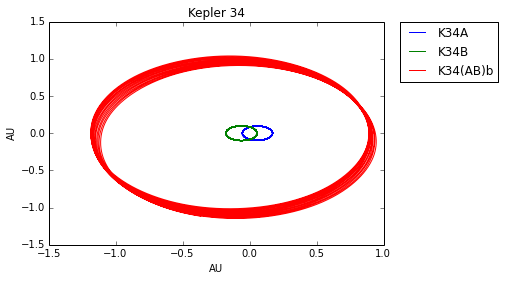

In [12]:
from pylab import *
k34ao = plot(k34a[0][0:10000],k34a[1][0:10000],label='K34A')
k34bo = plot(k34b[0][0:10000],k34b[1][0:10000],label='K34B')
k34po = plot(k34p[0][0:10000],k34p[1][0:10000],label='K34(AB)b')
ylabel('AU')
xlabel('AU')
title('Kepler 34')
l=legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

That's cool, but it'd be great to be able to see how it changes over time. To do that, we'll first define a function to plot each ellipse over a shorter interval, like 1 year. Note that we declare the coordinate arrays as global so that they don't have to be passed in as arguments.

In [13]:
global k34a,k34b,k34p
def plotorbit(year):
    t1=year*1000
    t2=(year+1)*1000
    k34ao = plot(k34a[0][t1:t2],k34a[1][t1:t2],label='K34A')
    k34bo = plot(k34b[0][t1:t2],k34b[1][t1:t2],label='K34B')
    k34po = plot(k34p[0][t1:t2],k34p[1][t1:t2],label='K34(AB)b')
    xlim(-1.5,1.5)
    ylim(-1.5,1.5)
    xlabel('AU')
    ylabel('AU')
    title('Kepler 34 year '+str(year))
    l=legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Now we'll use the "interact" widget from iPyWidgets. For each item in its provided range of parameters, it will call the provided function and pass the parameters as arguments. This will provided us with a plot that we can adjust to the desired point in time.

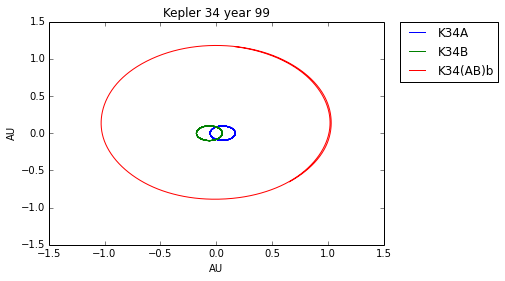

In [14]:
from ipywidgets import *
n=interact(plotorbit,year=(0,99,1))

Note the orbit's wobble--this system is interesting from a dynamical perspective because the gravitational source is very much *not* a point source. Instead, we have two sun-mass stars orbiting at some distance, but not too far as to avoid strongly interacting. This means that the gravitational potential well should be constantly changing a bit, leading to wobbles in the planet's orbit. It also means that the planet passes in and out of the habitable zone on a very fast timescale.

# Introducing another planet

So that's great--we've successfully simulated the Kepler-34 circumbinary planetary system to the best of our knowledge and measurements. And while the orbit wobbles, it appears stable. Given that there aren't really many other bodies to interact with, that's not terrible surprising. But what if there were another planet that we haven't yet observed? K34(AB)b has a period of nearly a year--that means that ordinarily it would be extremely hard for Kepler to detect it. It was detected because it transited in front of both stars in a short time frame. But another planet could be lurking in a wider orbit and just not have transited in front of the stars yet. So let's add a hypothetical planet. We'll give it the same mass, and stick it out at 1.5 AU--the same orbital radius as Mars. These planets are much larger than Earth and Mars, and so will interact more strongly, but we'll at least see if there's a stable configuration.

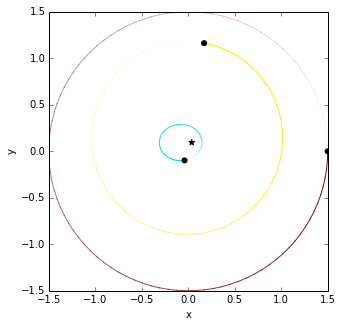

In [15]:
mp2 = mp
ap2 = 1.5
sim.add(m=mp2,a=ap2,e=0.,primary=sim.calculate_com(),id=4)
sim.move_to_com()
orb=rebound.OrbitPlot(sim,color=True,trails=True)


Here we've used Rebound's own orbit plotting utility to take a brief look at what we're starting with. Note that Rebound has trouble with binary systems, and wants to call one star the primary central star, and so doesn't give it an orbit. We'll integrate this one for 200 years, again with 1000 timesteps in a year.

In [16]:
years= 200
tmax = years*2*np.pi
times= np.linspace(0,tmax,num=years*1000)
k34a = np.zeros([2,len(times)])
k34b = np.zeros([2,len(times)])
k34abb = np.zeros([2,len(times)])
k34abc = np.zeros([2,len(times)])
i=0
while i<len(times):
    sim.integrate(times[i])
    sim.move_to_com()
    k34a[0][i]=sim.particles[0].x
    k34a[1][i]=sim.particles[0].y
    k34b[0][i]=sim.particles[1].x
    k34b[1][i]=sim.particles[1].y
    k34abb[0][i]=sim.particles[2].x
    k34abb[1][i]=sim.particles[2].y
    k34abc[0][i]=sim.particles[3].x
    k34abc[1][i]=sim.particles[3].y
    i+=1
    

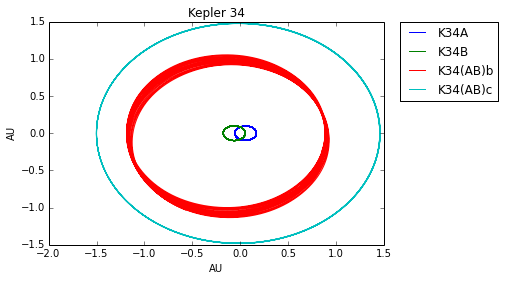

In [17]:
k34ao = plot(k34a[0][0:10000],k34a[1][0:10000],label='K34A')
k34bo = plot(k34b[0][0:10000],k34b[1][0:10000],label='K34B')
k34abbo = plot(k34abb[0][0:10000],k34abb[1][0:10000],label='K34(AB)b')
k34abco = plot(k34abc[0][0:10000],k34abc[1][0:10000],label='K34(AB)c')
ylabel('AU')
xlabel('AU')
title('Kepler 34')
l=legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [18]:
global k34abb,k34abc
def plotorbit2(year):
    t1=year*1000
    t2=(year+1)*1000 + 300
    k34ao = plot(k34a[0][t1:t2],k34a[1][t1:t2],label='K34A')
    k34bo = plot(k34b[0][t1:t2],k34b[1][t1:t2],label='K34B')
    k34abbo = plot(k34abb[0][t1:t2],k34abb[1][t1:t2],label='K34(AB)b')
    k34abco = plot(k34abc[0][t1:t2],k34abc[1][t1:t2],label='K34(AB)c')
    xlim(-1.5,1.5)
    ylim(-1.5,1.5)
    xlabel('AU')
    ylabel('AU')
    title('Kepler 34 year '+str(year))
    l=legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

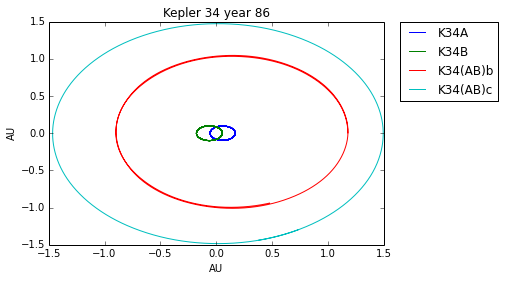

In [19]:
n=interact(plotorbit2,year=(0,years-1,1))

That clearly doesn't do much. What if instead we placed the planet closer to K34(AB)b? Say, at 1.3 AU? We can use the remove function along with the ID we assigned the extra planet last time to replace it with a better planet that's more interesting.

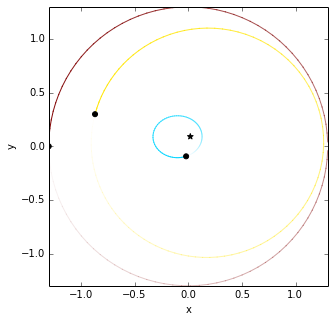

In [20]:
sim.remove(id=4)
mp2 = mp
ap2 = 1.3
sim.add(m=mp2,a=ap2,e=0.,f=np.pi,primary=sim.calculate_com(),id=5)
sim.move_to_com()
orb=rebound.OrbitPlot(sim,color=True,trails=True)

This time let's run for 500 years to see what happens. Feel free to go make a cup of tea; this could take a minute or two depending on your computer's speed.

In [21]:
years= 500
tmax = years*2*np.pi
times= np.linspace(0,tmax,num=years*1000)
k34a = np.zeros([2,len(times)])
k34b = np.zeros([2,len(times)])
k34abb = np.zeros([2,len(times)])
#k34abc = np.zeros([2,len(times)])
k34abd = np.zeros([2,len(times)])
i=0
while i<len(times):
    sim.integrate(times[i])
    sim.move_to_com()
    k34a[0][i]=sim.particles[0].x
    k34a[1][i]=sim.particles[0].y
    k34b[0][i]=sim.particles[1].x
    k34b[1][i]=sim.particles[1].y
    k34abb[0][i]=sim.particles[2].x
    k34abb[1][i]=sim.particles[2].y
#    k34abc[0][i]=sim.particles[3].x
#    k34abc[1][i]=sim.particles[3].y
    k34abd[0][i]=sim.particles[3].x
    k34abd[1][i]=sim.particles[3].y
    i+=1
    

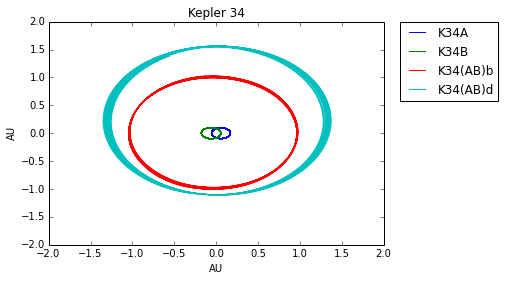

In [22]:
k34ao = plot(k34a[0][0:10000],k34a[1][0:10000],label='K34A')
k34bo = plot(k34b[0][0:10000],k34b[1][0:10000],label='K34B')
k34abbo = plot(k34abb[0][0:10000],k34abb[1][0:10000],label='K34(AB)b')
#k34abco = plot(k34abc[0][0:10000],k34abc[1][0:10000],label='K34ABc')
k34abdo = plot(k34abd[0][0:10000],k34abd[1][0:10000],label='K34(AB)d')
ylabel('AU')
xlabel('AU')
xlim(-2,2)
ylim(-2,2)
title('Kepler 34')
l=legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

That's promising--it's clear that interactions have led to more activity in the outer planet's orbit.

In [25]:
global k34abd
def plotorbit3(year):
    t1=year*1000
    t2=(year+1)*1000 + 300
    k34ao = plot(k34a[0][t1:t2],k34a[1][t1:t2],label='K34A')
    k34bo = plot(k34b[0][t1:t2],k34b[1][t1:t2],label='K34B')
    k34abbo = plot(k34abb[0][t1:t2],k34abb[1][t1:t2],label='K34(AB)b')
#    k34abco = plot(k34abc[0][t1:t2],k34abc[1][t1:t2],label='K34ABc')
    k34abdo = plot(k34abd[0][t1:t2],k34abd[1][t1:t2],label='K34(AB)d')
    xlim(-1.5,1.5)
    ylim(-1.5,1.5)
    xlabel('AU')
    ylabel('AU')
    title('Kepler 34 year '+str(year))
    l=legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

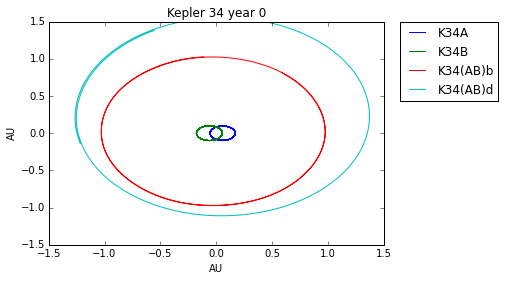

In [26]:
n=interact(plotorbit3,year=(0,500,1))

Now we're talking!

## An inner planet?

Would an inner planet survive? We can find out. Let's place a smaller planet, say 30% of K34(AB)b's mass, at 0.7 AU and see what happens. We'll refresh everything first.

In [27]:
sim2=rebound.Simulation()
aa = 0.22882
ee = 0.52087
ma = 1.0479
mb = 1.0208
ii = 0.4966*np.pi/180.
mp = 2.1e-4
ap = 1.0896
tp = 0.79075154
ep = 0.182
sim2.add(m=ma)
sim2.add(m=mb,a=aa,e=ee,l=300.1970*np.pi/180,primary=sim2.particles[0])
sim2.move_to_com()
sim2.add(m=mp,a=ap,e=ep,inc=ii,Omega=-1.74*np.pi/180.)
sim2.move_to_com()

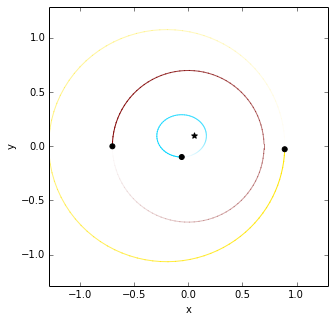

In [28]:
m3 = 0.3*mp
a3 = 0.7
sim2.add(m=m3,a=a3,e=0.,f=np.pi,primary=sim2.calculate_com())
sim2.move_to_com()
rb=rebound.OrbitPlot(sim2,color=True,trails=True)

We can probably expect this one to evolve fairly rapidly, so we'll go back down to 100 years, but we'll do 10,000 timesteps per year this time--about 50 minutes per timestep. If you finished that cup of tea, feel free to make a another one--this one will run for 1 million timesteps.

In [30]:
years= 100
tmax = years*2*np.pi
times= np.linspace(0,tmax,num=years*10000)
k34a = np.zeros([2,len(times)])
k34b = np.zeros([2,len(times)])
k34abb = np.zeros([2,len(times)])
k34abe = np.zeros([2,len(times)])
i=0
while i<len(times):
    sim2.integrate(times[i])
    sim2.move_to_com()
    k34a[0][i]=sim2.particles[0].x
    k34a[1][i]=sim2.particles[0].y
    k34b[0][i]=sim2.particles[1].x
    k34b[1][i]=sim2.particles[1].y
    k34abb[0][i]=sim2.particles[2].x
    k34abb[1][i]=sim2.particles[2].y
    k34abe[0][i]=sim2.particles[3].x
    k34abe[1][i]=sim2.particles[3].y
    i+=1
    

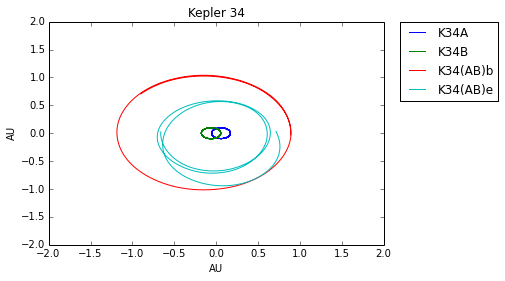

In [31]:
k34ao = plot(k34a[0][0:10000],k34a[1][0:10000],label='K34A')
k34bo = plot(k34b[0][0:10000],k34b[1][0:10000],label='K34B')
k34abbo = plot(k34abb[0][0:10000],k34abb[1][0:10000],label='K34(AB)b')
k34abeo = plot(k34abe[0][0:10000],k34abe[1][0:10000],label='K34(AB)e')
ylabel('AU')
xlabel('AU')
xlim(-2,2)
ylim(-2,2)
title('Kepler 34')
l=legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Doesn't look good for our poor little planet, does it?

In [32]:
global k34abe
def plotorbit3(year):
    t1=year*1000
    t2=(year+1)*1000 + 10000
    k34ao = plot(k34a[0][t1:t2],k34a[1][t1:t2],label='K34A')
    k34bo = plot(k34b[0][t1:t2],k34b[1][t1:t2],label='K34B')
    k34abbo = plot(k34abb[0][t1:t2],k34abb[1][t1:t2],label='K34(AB)b')
    k34abeo = plot(k34abe[0][t1:t2],k34abe[1][t1:t2],label='K34(AB)e')
    xlim(-1.5,1.5)
    ylim(-1.5,1.5)
    xlabel('AU')
    ylabel('AU')
    title('Kepler 34 year '+str(year*0.1))
    l=legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

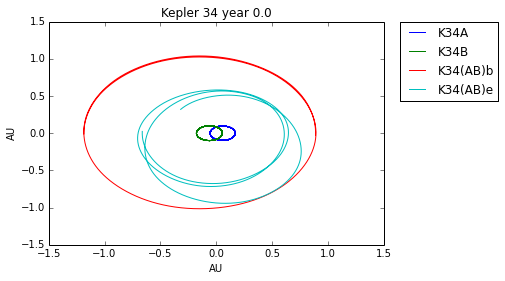

In [33]:
n=interact(plotorbit3,year=(0,1000,1))

Chances are, there aren't really any planets closer in than 1 AU.